## Explore Building Inventory to Find Residential Structures 
Steps required to make the Probabilistic Housing Unit Allocation work.

Building footprint data now includes blockid, placeid, puma, parcelid and parcel data
With all of this information it should be possible to explore the building footprint data to find most likely residential structures.

With a good count of structures the number of housing units estimated by the Census can be distributed to building footprints.

To Do:
1. Read in cleaned building footprint data with census block and parcel data
2. Identify Residential Structures
3. Count residential structures by block
4. Estimate the number of residential housing units (addressp points) in each structure

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pysal as ps
import math as math
import numpy as np
import geopandas as gpd
import pandas as pd
import shapely
import folium as fm # folium has more dynamic maps - but requires internet connection
import os # For saving output to path

C:\Users\nathanael99\AppData\Local\Continuum\anaconda3\envs\pyincore20190618\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
# Display versions being used - important information for replication
import sys
print("Python Version     ", sys.version)
print("pysal version:     ", ps.__version__)
print("numpy version:     ", np.__version__)
print("geopandas version: ", gpd.__version__)
print("pandas version:    ", pd.__version__)
print("shapely version:   ", shapely.__version__)
print("folium version:    ", fm.__version__)

Python Version      3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
pysal version:      2.0.0
numpy version:      1.16.4
geopandas version:  0.5.0
pandas version:     0.24.2
shapely version:    1.6.4.post1
folium version:     0.9.1


In [3]:
# Store Program Name for output files to have the same name
programname = "IN-CORE_1dv2_Joplin_EstimateAddressPoints_2019-07-11"
# Make directory to save output
if not os.path.exists(programname):
    os.mkdir(programname)

## Obtain data from previous program - Building Inventory with Parcel ID
The previous program (IN-CORE_1cv2_Joplin_CleanBuildingInventory_2019) combined parcel data with the building inventory. With this information residential buildings can be identified with greater certaintity.


In [4]:
source_program = "IN-CORE_1cv2_Joplin_CleanBuildingInventory_2019-07-11"
building_csv = source_program+"/"+source_program+"_EPSG4326.csv"
building_df = pd.read_csv(building_csv)
building_gdf = gpd.GeoDataFrame(building_df)
building_gdf.head()

,Unnamed: 0,bldg_id,parid,BLOCKID10,STATEFP10,COUNTYFP10,TRACTCE10,PUMGEOID10,PUMNAME10,PLCGEOID10,...,Zoning,APRBLDG,APRLAND,APRTOT,CLASS,STRUCTURE,YRBLT,classv2,taxsheetv2,prclbldsum
0,0,B0000001,P16703610001025000,290970102003000,29.0,97.0,10200.0,2902800.0,Jasper & Newton Counties PUMA,2937592.0,...,R1,43070.0,11770.0,54840.0,NaN,NaN,1945.0,NaN,2010 Res,1.0
1,1,B0000002,P16703610001028000,290970102003000,29.0,97.0,10200.0,2902800.0,Jasper & Newton Counties PUMA,2937592.0,...,R1,62810.0,9450.0,72260.0,NaN,NaN,1966.0,NaN,2010 Res,1.0
2,2,B0000003,P16703610001027000,290970102003000,29.0,97.0,10200.0,2902800.0,Jasper & Newton Counties PUMA,2937592.0,...,CO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,3,B0000004,P16703610001029000,290970102003000,29.0,97.0,10200.0,2902800.0,Jasper & Newton Counties PUMA,2937592.0,...,R1,77220.0,8890.0,86110.0,NaN,NaN,1965.0,NaN,2010 Res,1.0
4,4,B0000005,P16703610001059000,290970102003000,29.0,97.0,10200.0,2902800.0,Jasper & Newton Counties PUMA,2937592.0,...,C1,48820.0,11470.0,60290.0,NaN,NaN,1955.0,NaN,2010 Res,1.0


In [5]:
# Check Columns
cols = [col for col in building_gdf]
cols

['Unnamed: 0',
 'bldg_id',
 'parid',
 'BLOCKID10',
 'STATEFP10',
 'COUNTYFP10',
 'TRACTCE10',
 'PUMGEOID10',
 'PUMNAME10',
 'PLCGEOID10',
 'PLCNAME10',
 'ADDRESS1',
 'HOUSE_NO',
 'archtype',
 'objectid',
 'parid_card',
 'struct_typ',
 'str_prob',
 'year_built',
 'no_stories',
 'a_stories',
 'b_stories',
 'bsmt_type',
 'sq_foot',
 'gsq_foot',
 'occ_type',
 'occ_detail',
 'major_occ',
 'broad_occ',
 'appr_bldg',
 'repl_cst',
 'str_cst',
 'nstra_cst',
 'nstrd_cst',
 'dgn_lvl',
 'cont_val',
 'efacility',
 'dwell_unit',
 'str_typ2',
 'occ_typ2',
 'tract_id',
 'guid',
 'x',
 'y',
 'geometry',
 'rppnt4326',
 'bply4326',
 'gsq_meter',
 'HOUSING10',
 'apcount',
 'gqpop10',
 'POP10',
 'Zoning',
 'APRBLDG',
 'APRLAND',
 'APRTOT',
 'CLASS',
 'STRUCTURE',
 'YRBLT',
 'classv2',
 'taxsheetv2',
 'prclbldsum']

In [6]:
# Geomtry type needs to be converted to geo series polygons
building_gdf['geometry'].geom_type.describe()

count     0
unique    0
dtype: int64

In [7]:
# Use shapely.wkt loads to convert WKT to GeoSeries
from shapely.wkt import loads

building_gdf['rppnt4326'] = building_gdf['rppnt4326'].apply(lambda x: loads(x))
building_gdf['bply4326'] = building_gdf['bply4326'].apply(lambda x: loads(x))
building_gdf['geometry'] = building_gdf['geometry'].apply(lambda x: loads(x))
building_gdf['geometry'].geom_type.describe()

count       28152
unique          2
top       Polygon
freq        28148
dtype: object

In [8]:
# Geodata frame requires geometry and CRS to be set
building_gdf = building_gdf.set_geometry(building_gdf['geometry'])
building_gdf.crs = {'init':'epsg:4326'}

In [9]:
# Check Unique IDs and Foreign Keys
building_gdf[['bldg_id','parid']].describe()

,bldg_id,parid
count,28152,24496
unique,28152,18409
top,B0012554,P16702620002006000
freq,1,61


## Limit Number of Buildings to Most Likely Residential Structures
Based on parcel data (from Jasper County) make assumptions about buildings that might be residential buildings. 

The goal is to reduce the number of buildings that are counted as residential address points and limit the allocation of housing units to buildings that are commercial.

The Joplin building data covers 2 counties - Jasper and Newton. There is parcel and zoning data for Jasper County but not for Newton County. In Newton county building footprint (square feet) may provide some details for residential structures.

## Explore Parcel Zoning and Tax Data


In [10]:
pd.crosstab(building_gdf['Zoning'], building_gdf['classv2'], margins=True, margins_name="Total")

classv2,A,C,CR,E,EC,ER,R,RC,Total
Zoning,,,,,,,,,
C1,0,93,2,7,0,0,70,0,172
C1-PD,0,26,0,2,0,0,0,0,28
C2,0,76,1,7,0,0,25,0,109
C2-PD,0,13,0,0,0,0,2,0,15
C3,0,224,11,5,0,0,36,3,279
C3-PD,0,8,0,0,0,0,3,0,11
CO,0,21,2,2,0,0,47,0,72
CO-PD,0,23,0,0,0,0,0,0,23
M1,0,1,0,0,0,0,0,0,1


A parcel in Jasper County can have one of four class tyeps (A,C,E, and R). At this point there is not a codebook that explicitly describes these meanings of A, C, E, and R - however we can assume that R = Residential and C = Commercial. E probably means Exempt. 
The Class codes CR, EC, ER, and RC come from the collapsed Tax data. These parcels have mixed class information. 

The cross tabulation between Class and Parcel Zoning provides some evidence that this assumption is correct. For Class R parcels 7,311 are R-1 Single-Family Residential. 1,715 are R-2 Two-Family Residential, 763 are R-3 Apartment House.

In [11]:
# Buildings by zoning where there is housing
pd.crosstab(columns=[building_gdf['apcount']>0],index=[building_gdf['Zoning']], margins=True, margins_name="Total")

apcount,False,True,Total
Zoning,,,
C1,17,299,316
C1-PD,5,35,40
C2,78,106,184
C2-PD,4,21,25
C3,49,448,497
C3-PD,4,19,23
CO,19,127,146
CO-PD,7,25,32
M1,11,3,14


In [12]:
# Buildings by class where there is housing
pd.crosstab(columns=[building_gdf['apcount']>0],index=[building_gdf['classv2']], margins=True, margins_name="Total")

apcount,False,True,Total
classv2,,,
A,0,1,1
C,389,1023,1412
CR,9,124,133
E,25,107,132
EC,0,1,1
ER,0,1,1
R,14,12730,12744
RC,0,23,23
Total,437,14010,14447


In [13]:
pd.crosstab(building_gdf['classv2'], building_gdf['taxsheetv2'], margins=True, margins_name="Total")

taxsheetv2,2010 Comm,2010 Comm2010 Res,2010 Res,Total
classv2,,,,
A,0,0,1,1
C,1365,21,26,1412
CR,8,118,7,133
E,50,7,75,132
EC,0,1,0,1
ER,0,0,1,1
R,188,54,12502,12744
RC,13,10,0,23
Total,1624,211,12612,14447


In [14]:
pd.crosstab(building_gdf['classv2'], building_gdf['COUNTYFP10'], margins=True, margins_name="Total")

COUNTYFP10,97.0,Total
classv2,,
A,1,1
C,1412,1412
CR,133,133
E,132,132
EC,1,1
ER,1,1
R,12744,12744
RC,23,23
Total,14447,14447


In [15]:
pd.crosstab(building_gdf['Zoning'], building_gdf['taxsheetv2'], margins=True, margins_name="Total")

taxsheetv2,2010 Comm,2010 Comm2010 Res,2010 Res,Total
Zoning,,,,
C1,144,5,141,290
C1-PD,29,0,10,39
C2,123,1,25,149
C2-PD,22,0,0,22
C3,328,14,86,428
C3-PD,16,0,5,21
CO,36,0,84,120
CO-PD,32,0,0,32
M1,4,0,0,4


In [16]:
pd.crosstab(building_gdf['Zoning'], building_gdf['archtype'], margins=True, margins_name="Total")

archtype,1,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Total
Zoning,,,,,,,,,,,,,,,,,
C1,157,0,55,24,5,1,0,0,0,2,3,1,2,5,0,61,316
C1-PD,11,2,9,1,0,1,0,0,1,0,0,0,0,0,0,15,40
C2,43,1,65,7,5,1,0,0,0,7,7,0,9,0,7,32,184
C2-PD,0,4,14,3,0,0,1,0,0,0,2,0,0,0,0,1,25
C3,150,12,185,50,2,0,0,0,0,5,3,4,4,0,0,82,497
C3-PD,6,0,8,5,0,0,0,0,0,0,0,1,1,0,0,2,23
CO,98,4,9,0,0,0,0,0,16,2,0,0,0,0,0,17,146
CO-PD,1,0,6,3,0,0,0,0,1,0,0,0,0,0,0,21,32
M1,0,0,3,5,0,0,0,0,0,0,0,0,0,0,0,6,14


In [17]:
pd.crosstab(building_gdf['classv2'], building_gdf['archtype'], margins=True, margins_name="Total")

archtype,1,5,6,7,8,9,10,12,13,14,15,16,17,18,19,Total
classv2,,,,,,,,,,,,,,,,
A,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
C,156,10,341,481,112,1,1,4,8,9,10,14,7,5,253,1412
CR,58,2,11,48,0,2,0,0,0,0,0,0,0,0,12,133
E,78,1,12,4,2,1,0,1,8,3,1,1,0,0,20,132
EC,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
ER,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
R,12479,37,35,72,0,2,0,2,5,0,0,0,1,2,109,12744
RC,8,15,0,0,0,0,0,0,0,0,0,0,0,0,0,23
Total,12782,65,399,605,114,6,1,7,21,12,11,15,8,7,394,14447


Building archetypes maybe helpful for identifing residential structures.
Table 1. Types of buildings assumed to exist in virtual community of Centerville
Building type	Building description
- T1	Residential wood building, small rectangular plan, gable roof, 1 story
- T2	Residential wood building, small square plan, gable roof, 2 stories
- T3	Residential wood building, medium rectangular plan, gable roof, 1 story
- T4	Residential wood building, medium rectangular plan, hip roof, 2 stories
- T5	Residential wood building, large rectangular plan, gable roof, 2 stories
- T6	Business and retail building (strip mall)
- T7	Light industrial building
- T8	Heavy industrial building
- T9	Elementary/middle school (unreinforced masonry)
- T10	High school (reinforced masonry)
- T11	Fire/police station
- T12	Hospital
- T13	Community center/church
- T14	Government building
- T15	Large big-box
- T16	Small big-box
- T17	Mobile home
- T18	Shopping center
- T19	Office building

Source: Memari, M., Attary, N., Masoomi, H., Mahmoud, H., van de Lindt, J. W., Pilkington, S. F., & Ameri, M. R. (2018). Minimal building fragility portfolio for damage assessment of communities subjected to tornadoes. Journal of Structural Engineering, 144(7), 04018072.

In [18]:
pd.crosstab(building_gdf['archtype'], building_gdf['COUNTYFP10'], margins=True, margins_name="Total")

COUNTYFP10,97.0,145.0,Total
archtype,,,
1,21889,2868,24757
5,88,58,146
6,678,58,736
7,880,83,963
8,150,5,155
9,36,3,39
10,50,0,50
11,7,1,8
12,21,20,41


## Planned use of Detailed Parcel and Building Foot Print Data

### For Parcels with Zoning and Tax Data
1. All R1 Parcels will be assigned 1 address point
2. All R2 Parcels will be assigned 2 address points
3. All R3 Parcels will be assigned 3 address points 
4. All R3 and R4 parcels will be prioritized to recieve additional address points.
4. Small building footprints (less than 300 sq feet - will not be counted as residential structures)

### For Parcels with Tax Data but no Zoning
1. All Class R parcels will be prioritized as residential
2. If a parcel is Class C and on the 2010 Commercial Tax Sheet the parcel will be assigned 0 residential address points
3. If a parcel has no other information but was on the Residential Tax Sheet assume it is residential.

In [19]:
building_gdf['residentialAP1'] = 0
building_gdf['residentialAP1'].label = "Residential Address Point Round 1"
building_gdf['residentialAP1'].note = "Residential Address Point - first attempt to assign residential address points to buildings"

In [20]:
building_gdf.loc[building_gdf['Zoning'] == "R1",'residentialAP1'] = 1
building_gdf.loc[building_gdf['Zoning'] == "R1-PD",'residentialAP1'] = 1
building_gdf.loc[building_gdf['Zoning'] == "R2",'residentialAP1'] = 2
building_gdf.loc[building_gdf['Zoning'] == "R2-PD",'residentialAP1'] = 2
building_gdf.loc[building_gdf['Zoning'] == "R3",'residentialAP1'] = 3
building_gdf.loc[building_gdf['Zoning'] == "R3-PD",'residentialAP1'] = 3
building_gdf.loc[building_gdf['Zoning'] == "R4",'residentialAP1'] = 1
pd.crosstab(building_gdf['Zoning'], building_gdf['residentialAP1'], margins=True, margins_name="Total")

residentialAP1,0,1,2,3,Total
Zoning,,,,,
C1,316,0,0,0,316
C1-PD,40,0,0,0,40
C2,184,0,0,0,184
C2-PD,25,0,0,0,25
C3,497,0,0,0,497
C3-PD,23,0,0,0,23
CO,146,0,0,0,146
CO-PD,32,0,0,0,32
M1,14,0,0,0,14


In [21]:
building_gdf.loc[(building_gdf['classv2'].isin(["R","RC","CR"])) & (building_gdf['residentialAP1']==0),'residentialAP1'] = 1
pd.crosstab(building_gdf['Zoning'], building_gdf['residentialAP1'], margins=True, margins_name="Total")

residentialAP1,0,1,2,3,Total
Zoning,,,,,
C1,244,72,0,0,316
C1-PD,40,0,0,0,40
C2,158,26,0,0,184
C2-PD,23,2,0,0,25
C3,447,50,0,0,497
C3-PD,20,3,0,0,23
CO,97,49,0,0,146
CO-PD,32,0,0,0,32
M1,14,0,0,0,14


In [22]:
pd.crosstab(building_gdf['taxsheetv2'], building_gdf['residentialAP1'], margins=True, margins_name="Total")

residentialAP1,0,1,2,3,Total
taxsheetv2,,,,,
2010 Comm,1771,128,69,157,2125
2010 Comm2010 Res,19,182,2,13,216
2010 Res,626,15016,3861,1341,20844
Total,2416,15326,3932,1511,23185


In [23]:
# If Parcel is on the 2010 Residential Tax Sheet but is zoning is not residential assume residential
building_gdf.loc[(building_gdf['taxsheetv2']=="2010 Res") & 
                 (building_gdf['residentialAP1']==0),'residentialAP1'] = 1
pd.crosstab(building_gdf['taxsheetv2'], building_gdf['residentialAP1'], margins=True, margins_name="Total")

residentialAP1,0,1,2,3,Total
taxsheetv2,,,,,
2010 Comm,1771,128,69,157,2125
2010 Comm2010 Res,19,182,2,13,216
2010 Res,0,15642,3861,1341,20844
Total,1790,15952,3932,1511,23185


In [24]:
# If a parcel is Class C and on the 2010 Commercial Tax Sheet make Residential Address Point 0
building_gdf.loc[(building_gdf['classv2'].isin(["R","RC","CR"])==False) & 
                 (building_gdf['taxsheetv2']=="2010 Comm") & 
                 (building_gdf['Zoning']=="R1"),'residentialAP1'] = 0
pd.crosstab(building_gdf['taxsheetv2'], building_gdf['residentialAP1'], margins=True, margins_name="Total")

residentialAP1,0,1,2,3,Total
taxsheetv2,,,,,
2010 Comm,1818,81,69,157,2125
2010 Comm2010 Res,19,182,2,13,216
2010 Res,0,15642,3861,1341,20844
Total,1837,15905,3932,1511,23185


## Assume all buildings in Newton County are Residential

In [25]:
pd.crosstab(building_gdf['COUNTYFP10'], building_gdf['residentialAP1'], margins=True, margins_name="Total")

residentialAP1,0,1,2,3,Total
COUNTYFP10,,,,,
97.0,2621,16260,4075,1627,24583
145.0,3569,0,0,0,3569
Total,6190,16260,4075,1627,28152


In [26]:
# For Newton County Make residentialAP1 = 1 to 1 for all buildings
building_gdf.loc[building_gdf['COUNTYFP10'] == 145,'residentialAP1'] = 1
pd.crosstab(building_gdf['COUNTYFP10'], building_gdf['residentialAP1'], margins=True, margins_name="Total")

residentialAP1,0,1,2,3,Total
COUNTYFP10,,,,,
97.0,2621,16260,4075,1627,24583
145.0,0,3569,0,0,3569
Total,2621,19829,4075,1627,28152


## Assume all buildings with an area of less than 30 square meters is has no address point
The building footprint data includes many small buildings that could be detached garages or sheds.

In [27]:
# remove small buildings from residential bulding list
building_gdf.loc[building_gdf['gsq_meter'] < 30,'residentialAP1'] = 0
pd.crosstab(building_gdf['Zoning'], building_gdf['residentialAP1'])

residentialAP1,0,1,2,3
Zoning,,,,
C1,180,136,0,0
C1-PD,31,9,0,0
C2,156,28,0,0
C2-PD,23,2,0,0
C3,399,98,0,0
C3-PD,18,5,0,0
CO,60,86,0,0
CO-PD,32,0,0,0
M1,14,0,0,0


### Extend small square footage to buildings assumed to have 2 to 3 address points

In [28]:
# Look at shape area divided by the number of address points
building_gdf['gsq_meter_by_AP'] = building_gdf['gsq_meter'] / building_gdf['residentialAP1']
building_gdf['gsq_meter_by_AP'].describe()

count    2.815200e+04
mean              inf
std               NaN
min      1.003998e+01
25%      8.854690e+01
50%      1.648335e+02
75%      2.693805e+02
max               inf
Name: gsq_meter_by_AP, dtype: float64

In [29]:
building_gdf['gsq_meter_by_AP'].loc[building_gdf['gsq_meter_by_AP'] < 30 ].describe()

count    764.000000
mean      22.191337
std        4.799981
min       10.039977
25%       18.200337
50%       22.606294
75%       26.255939
max       29.985586
Name: gsq_meter_by_AP, dtype: float64

In [30]:
# remove small buildings from residential bulding list
building_gdf.loc[building_gdf['gsq_meter_by_AP'] < 30,'residentialAP1'] = 0
pd.crosstab(building_gdf['Zoning'], building_gdf['residentialAP1'], margins=True, margins_name="Total")

residentialAP1,0,1,2,3,Total
Zoning,,,,,
C1,180,136,0,0,316
C1-PD,31,9,0,0,40
C2,156,28,0,0,184
C2-PD,23,2,0,0,25
C3,399,98,0,0,497
C3-PD,18,5,0,0,23
CO,60,86,0,0,146
CO-PD,32,0,0,0,32
M1,14,0,0,0,14


In [31]:
# For Parcels with Designation Residential remove smaller building on parcel
# It looks like in the Building Inventory if there is no House Number the building is tha auxillary building
building_gdf.loc[(building_gdf['prclbldsum'] == 2) &
                 (building_gdf['HOUSE_NO'].isna()),'residentialAP1'] = 0
pd.crosstab(building_gdf['Zoning'], building_gdf['residentialAP1'], margins=True, margins_name="Total")

residentialAP1,0,1,2,3,Total
Zoning,,,,,
C1,189,127,0,0,316
C1-PD,31,9,0,0,40
C2,161,23,0,0,184
C2-PD,23,2,0,0,25
C3,407,90,0,0,497
C3-PD,18,5,0,0,23
CO,68,78,0,0,146
CO-PD,32,0,0,0,32
M1,14,0,0,0,14


In [32]:
# If Address Point Count (Housing10 + Group Quarters) from Census is 0 then Residential Address Point is also 0
building_gdf.loc[building_gdf['apcount'] == 0,'residentialAP1'] = 0
pd.crosstab(building_gdf['Zoning'], building_gdf['residentialAP1'], margins=True, margins_name="Total")

residentialAP1,0,1,2,3,Total
Zoning,,,,,
C1,189,127,0,0,316
C1-PD,31,9,0,0,40
C2,161,23,0,0,184
C2-PD,23,2,0,0,25
C3,407,90,0,0,497
C3-PD,18,5,0,0,23
CO,68,78,0,0,146
CO-PD,32,0,0,0,32
M1,14,0,0,0,14


Text(0, 0.5, 'Residential Address Point Count')

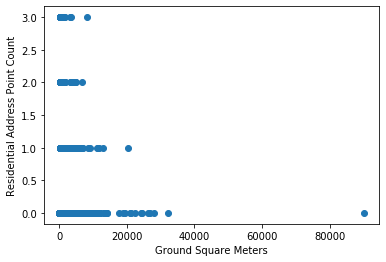

In [33]:
# Compare Residential Address Point Count to Square Footage
x = building_gdf['gsq_meter']
y = building_gdf['residentialAP1']
plt.scatter(x, y)
plt.xlabel("Ground Square Meters")
plt.ylabel("Residential Address Point Count")

In [34]:
building_gdf['gsq_meter'].groupby(building_gdf['residentialAP1']).describe()

,count,mean,std,min,25%,50%,75%,max
residentialAP1,,,,,,,,
0,6614.0,393.756252,1770.592690,0.000336,48.146949,79.762566,227.718975,90132.331610
1,17319.0,222.148552,350.278464,30.494645,131.283606,183.643994,249.581940,20216.545735
2,2973.0,171.762246,250.293965,60.472302,112.259530,142.225596,176.481417,6711.545752
3,1246.0,229.738183,296.770005,90.225096,130.671126,168.991018,248.391296,8173.997830


In [35]:
building_gdf[['bldg_id','COUNTYFP10','HOUSING10','apcount','HOUSE_NO','prclbldsum',
              'Zoning','classv2','taxsheetv2','gsq_meter','residentialAP1']].head(20)

,bldg_id,COUNTYFP10,HOUSING10,apcount,HOUSE_NO,prclbldsum,Zoning,classv2,taxsheetv2,gsq_meter,residentialAP1
0,B0000001,97.0,103.0,103.0,2519,1.0,R1,NaN,2010 Res,107.940427,1
1,B0000002,97.0,103.0,103.0,2515,1.0,R1,NaN,2010 Res,169.494274,1
2,B0000003,97.0,103.0,103.0,2511,1.0,CO,NaN,NaN,93.622453,0
3,B0000004,97.0,103.0,103.0,2511,1.0,R1,NaN,2010 Res,185.178358,1
4,B0000005,97.0,103.0,103.0,2501,1.0,C1,NaN,2010 Res,202.291430,1
5,B0000006,97.0,103.0,103.0,2419,1.0,C1,NaN,2010 Res,189.289577,1
6,B0000007,97.0,103.0,103.0,2401,1.0,R1,NaN,2010 Res,212.088491,1
7,B0000008,97.0,103.0,103.0,2400,1.0,R1,NaN,2010 Res,228.627892,1
8,B0000009,97.0,103.0,103.0,2408,1.0,R1,NaN,2010 Res,220.681636,1
9,B0000010,97.0,103.0,103.0,2420,1.0,R1,NaN,2010 Res,345.690083,1


## Sum Residential Addresspoints (first attempt) by blockid

In [36]:
# sum Buildings over the column BLOCKID.
# https://www.geeksforgeeks.org/python-pandas-dataframe-sum/
block_rap1_gdf = building_gdf[['BLOCKID10','residentialAP1']]
block_rap1_gdf['bldgcount'] = 1
block_rap1_gdf_sum = block_rap1_gdf.groupby(['BLOCKID10']).sum()
block_rap1_gdf_sum.head()

C:\Users\nathanael99\AppData\Local\Continuum\anaconda3\envs\pyincore20190618\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,residentialAP1,bldgcount
BLOCKID10,,
290970101001000,5,5
290970101001001,2,2
290970101001002,3,4
290970101001003,29,33
290970101001006,5,10


In [37]:
block_rap1_gdf_sum['residentialAP1'].describe()

count    1829.000000
mean       14.763805
std        17.273099
min         0.000000
25%         5.000000
50%        12.000000
75%        19.000000
max       217.000000
Name: residentialAP1, dtype: float64

## Merge Sum of Estimated Sum of Address Points with Census Block Data

In [38]:
# Read in Census Block Data
source_program = 'IN-CORE_1av2_Joplin_CleanBlockData_2019-07-10'
census_blocks_csv = source_program+"/"+source_program+"EPSG4269.csv"
census_blocks_df = pd.read_csv(census_blocks_csv)
census_blocks_df.head()

,Unnamed: 0,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,HOUSING10,POP10,geometry,...,blk104269,blockid,apcount,pop10,gqpop10,popdiff,PLCGEOID10,PLCNAME10,PUMGEOID10,PUMNAME10
0,0,29,97,12100,1047,290970121001047,N,2,4,"POLYGON ((-94.13775 37.32550000000001, -94.138...",...,"POLYGON ((-94.13775 37.32550000000001, -94.138...",2.909701e+14,2.0,4.0,0.0,0.0,NaN,NaN,2902800,Jasper & Newton Counties PUMA
1,1,29,97,12100,1050,290970121001050,N,3,7,"POLYGON ((-94.137637 37.328675, -94.119315 37....",...,"POLYGON ((-94.137637 37.328675, -94.119315 37....",2.909701e+14,3.0,7.0,0.0,0.0,NaN,NaN,2902800,Jasper & Newton Counties PUMA
2,2,29,97,12100,1094,290970121001094,N,4,13,"POLYGON ((-94.214761 37.293836, -94.230751 37....",...,"POLYGON ((-94.214761 37.293836, -94.230751 37....",2.909701e+14,4.0,13.0,0.0,0.0,NaN,NaN,2902800,Jasper & Newton Counties PUMA
3,3,29,97,12100,1093,290970121001093,N,5,5,"POLYGON ((-94.197294 37.27723599999999, -94.19...",...,"POLYGON ((-94.197294 37.27723599999999, -94.19...",2.909701e+14,5.0,5.0,0.0,0.0,NaN,NaN,2902800,Jasper & Newton Counties PUMA
4,4,29,97,12100,1130,290970121001130,N,4,9,"POLYGON ((-94.151792 37.276275, -94.1519139999...",...,"POLYGON ((-94.151792 37.276275, -94.1519139999...",2.909701e+14,4.0,9.0,0.0,0.0,NaN,NaN,2902800,Jasper & Newton Counties PUMA


In [39]:
# Merge Sum of Residential Address Points with Census Counts
census_blocks_df_rap1 = pd.merge(census_blocks_df, block_rap1_gdf_sum,
                                  left_on='BLOCKID10', right_on='BLOCKID10', how='left')
displaycols = ['BLOCKID10','residentialAP1','apcount']
condition = census_blocks_df_rap1['residentialAP1']==census_blocks_df_rap1['apcount']
census_blocks_df_rap1[displaycols].loc[condition].describe()

,BLOCKID10,residentialAP1,apcount
count,4.790000e+02,479.000000,479.000000
mean,2.910343e+14,11.812109,11.812109
std,1.635169e+11,7.719872,7.719872
min,2.909701e+14,1.000000,1.000000
25%,2.909701e+14,7.000000,7.000000
50%,2.909701e+14,11.000000,11.000000
75%,2.909701e+14,16.000000,16.000000
max,2.914502e+14,65.000000,65.000000


### Error Check 1 - Are there Blocks in Joplin that have Housing Units by the Estimated Number of Housing Units is 0 or Missing?

Text(0, 0.5, 'Housing Unit Count')

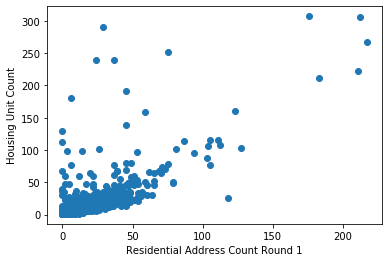

In [40]:
# Compare Bldg Count to Housing 10
x = census_blocks_df_rap1['residentialAP1']
y = census_blocks_df_rap1['apcount']
plt.scatter(x, y)
plt.xlabel("Residential Address Count Round 1")
plt.ylabel("Housing Unit Count")

## Error Check Options
### Two Areas to Focus on Inside Joplin Area and Outside Joplin Area
#### For places outside of Joplin Census Boundary there could be Buildings


In [41]:
census_blocks_df_rap1.loc[census_blocks_df_rap1['PLCNAME10'] == "Joplin",'Joplin'] = "Joplin"
census_blocks_df_rap1.loc[census_blocks_df_rap1['PLCNAME10'] != "Joplin",'Joplin'] = "Not Joplin"

In [42]:
def block_error_check_addresspoints(census_blocks_df, expected_count, estimated_count,building_count, ErrorCheck):
    # Create Error Varaible
    census_blocks_df[ErrorCheck] = "0. Not Checked"

    basecondition = (census_blocks_df[ErrorCheck] == "0. Not Checked")
    census_blocks_df.loc[(census_blocks_df[expected_count].isna())
                         & basecondition, ErrorCheck] = "1. HU=0"
    census_blocks_df.loc[(census_blocks_df[expected_count] == census_blocks_df[estimated_count])
                         & basecondition, ErrorCheck] = "2. HU=AP"
    census_blocks_df.loc[(census_blocks_df[expected_count] < census_blocks_df[estimated_count])
                         & basecondition, ErrorCheck] = "3. HU<AP"
    census_blocks_df.loc[(census_blocks_df[expected_count] > census_blocks_df[estimated_count])
                         & basecondition, ErrorCheck] = "4. HU>AP"
    census_blocks_df.loc[(census_blocks_df[expected_count] > 0) & (census_blocks_df[estimated_count] == 0)
                         & basecondition, ErrorCheck] = "5. HU > 0, AP = 0"
    census_blocks_df.loc[(census_blocks_df[expected_count] > 0) & (census_blocks_df[estimated_count].isna()) & 
                         (census_blocks_df[building_count] > 0)
                         , ErrorCheck] = "6. HU > 0, AP = Missing, But buildings present"
    census_blocks_df.loc[(census_blocks_df[expected_count] > 0) & (census_blocks_df[estimated_count].isna())
                         , ErrorCheck] = "7. HU > 0, AP = Missing"
    census_blocks_df.loc[(census_blocks_df[expected_count] > 0) & (census_blocks_df[building_count].isna())
                         , ErrorCheck] = "8. HU > 0, Building Count = Missing"
    census_blocks_df.loc[(census_blocks_df[expected_count].isna()) & (census_blocks_df[building_count].isna())
                         , ErrorCheck] = "9. HU = 0, Building Count = Missing"
    
block_error_check_addresspoints(census_blocks_df_rap1,'apcount','residentialAP1','bldgcount','ErrorCheck1')
pd.crosstab(census_blocks_df_rap1['ErrorCheck1'], census_blocks_df_rap1['Joplin'],
            margins=True, margins_name="Total")

Joplin,Joplin,Not Joplin,Total
ErrorCheck1,,,
1. HU=0,222,16,238
2. HU=AP,451,28,479
3. HU<AP,702,44,746
4. HU>AP,235,92,327
"5. HU > 0, AP = 0",26,13,39
"8. HU > 0, Building Count = Missing",31,4702,4733
"9. HU = 0, Building Count = Missing",358,2701,3059
Total,2025,7596,9621


In [43]:
# look at estimated Address Points by Error
census_blocks_df_rap1['residentialAP1'].groupby(census_blocks_df_rap1['ErrorCheck1']).describe()

,count,mean,std,min,25%,50%,75%,max
ErrorCheck1,,,,,,,,
1. HU=0,238.0,1.239496,2.638044,0.0,0.0,0.0,1.0,19.0
2. HU=AP,479.0,11.812109,7.719872,1.0,7.0,11.0,16.0,65.0
3. HU<AP,746.0,19.599196,14.792305,2.0,10.0,16.0,26.0,127.0
4. HU>AP,327.0,19.660550,28.819372,1.0,7.0,12.0,19.0,217.0
"5. HU > 0, AP = 0",39.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"8. HU > 0, Building Count = Missing",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"9. HU = 0, Building Count = Missing",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# For the 29 blocks with 0 address points and HU greater than 0 look at adding address points
displaycols = ['BLOCKID10','COUNTYFP10','PLCNAME10','residentialAP1','apcount','bldgcount','ErrorCheck1']
condition = (census_blocks_df_rap1['ErrorCheck1'] == "5. HU > 0, AP = 0") & (census_blocks_df_rap1['Joplin']=="Joplin")
census_blocks_df_rap1[displaycols].loc[condition]

,BLOCKID10,COUNTYFP10,PLCNAME10,residentialAP1,apcount,bldgcount,ErrorCheck1
51,290970110003000,97,Joplin,0.0,8.0,4.0,"5. HU > 0, AP = 0"
64,290970110005021,97,Joplin,0.0,2.0,1.0,"5. HU > 0, AP = 0"
102,290970102001002,97,Joplin,0.0,1.0,7.0,"5. HU > 0, AP = 0"
124,290970101001063,97,Joplin,0.0,130.0,2.0,"5. HU > 0, AP = 0"
356,290970102002009,97,Joplin,0.0,1.0,5.0,"5. HU > 0, AP = 0"
478,290970119003035,97,Joplin,0.0,1.0,2.0,"5. HU > 0, AP = 0"
733,290970110003002,97,Joplin,0.0,39.0,4.0,"5. HU > 0, AP = 0"
798,290970101001071,97,Joplin,0.0,13.0,9.0,"5. HU > 0, AP = 0"
1049,290970102002010,97,Joplin,0.0,3.0,2.0,"5. HU > 0, AP = 0"
1500,290970106001016,97,Joplin,0.0,36.0,3.0,"5. HU > 0, AP = 0"


In [45]:
census_blocks_df_rap1['DiffCount1'] = census_blocks_df_rap1['apcount'] - census_blocks_df_rap1['residentialAP1']
census_blocks_df_rap1 = census_blocks_df_rap1.rename(index=str, columns={
    "residentialAP1": "residentialAP1_sum", 
    "bldgcount": "bldgcount1_sum"})

In [46]:
# Merge Block level data with building level data
keepcolumns = ['BLOCKID10','residentialAP1_sum','bldgcount1_sum','DiffCount1','ErrorCheck1']

building_gdf_round2 = pd.merge(building_gdf, census_blocks_df_rap1[keepcolumns], 
                                  left_on='BLOCKID10', right_on='BLOCKID10', how='left')
# Convert Pandas Data Frame from Merge to Geodataframe
building_gdf_round2 = gpd.GeoDataFrame(building_gdf_round2, crs=building_gdf.crs)
# Check Merge to make sure all buildings are in the dataset
building_gdf_round2['bldg_id'].describe()

count        28152
unique       28152
top       B0012554
freq             1
Name: bldg_id, dtype: object

## Distribute Missing Address Points to Buildings Based on Area
\begin{equation*}
\frac{Area_k}{\left( \sum_{k=1}^n Area_k \right)}*DiffCount_i
\end{equation*}

In [47]:
# For Error Check = 5. HU > 0, AP = 0 - Make Each Building that is in the block a residential address point
pd.crosstab(building_gdf_round2['ErrorCheck1'], building_gdf_round2['residentialAP1'],
            margins=True, margins_name="Total")

residentialAP1,0,1,2,3,Total
ErrorCheck1,,,,,
1. HU=0,669,185,25,20,899
2. HU=AP,813,5485,37,33,6368
3. HU<AP,3104,6493,2753,874,13224
4. HU>AP,1772,5156,158,319,7405
"5. HU > 0, AP = 0",256,0,0,0,256
Total,6614,17319,2973,1246,28152


In [48]:
# For Error Code 5 Make each Building a Residential Building
building_gdf_round2.loc[(building_gdf_round2['ErrorCheck1'] == "5. HU > 0, AP = 0"),'residentialAP1']=1
pd.crosstab(building_gdf_round2['ErrorCheck1'], building_gdf_round2['residentialAP1'],
            margins=True, margins_name="Total")

residentialAP1,0,1,2,3,Total
ErrorCheck1,,,,,
1. HU=0,669,185,25,20,899
2. HU=AP,813,5485,37,33,6368
3. HU<AP,3104,6493,2753,874,13224
4. HU>AP,1772,5156,158,319,7405
"5. HU > 0, AP = 0",0,256,0,0,256
Total,6358,17575,2973,1246,28152


In [49]:
# Calcuate sum of Residential Area By Block
building_gdf_round2['Res_Area'] = 0
building_gdf_round2.loc[(building_gdf_round2['residentialAP1']>=1), 'Res_Area'] = building_gdf_round2['gsq_meter']
building_gdf_round2_area = building_gdf_round2[['BLOCKID10','Res_Area']]
building_gdf_round2_area.describe()

,BLOCKID10,Res_Area
count,2.815200e+04,28152.000000
mean,2.910310e+14,169.613007
std,1.597421e+11,316.466313
min,2.909701e+14,0.000000
25%,2.909701e+14,68.111269
50%,2.909701e+14,145.945821
75%,2.909701e+14,218.512466
max,2.914502e+14,20216.545735


In [50]:
building_gdf_round2_area_sum = building_gdf_round2_area.groupby(['BLOCKID10']).sum()
building_gdf_round2_area_sum = building_gdf_round2_area_sum.rename(columns={"Res_Area": "Sum_Res_Area"})
building_gdf_round2_area_sum.head()

,Sum_Res_Area
BLOCKID10,
290970101001000,581.023359
290970101001001,228.126477
290970101001002,755.359780
290970101001003,3404.343351
290970101001006,789.038971


In [51]:
building_gdf_round2_v2 = pd.merge(building_gdf_round2, building_gdf_round2_area_sum, 
                                  left_on='BLOCKID10', right_on='BLOCKID10', how='outer')
# Convert Pandas Data Frame from Merge to Geodataframe
building_gdf_round2_v2 = gpd.GeoDataFrame(building_gdf_round2_v2, crs=building_gdf.crs)
building_gdf_round2_v2['bldg_id'].describe()

count        28152
unique       28152
top       B0012554
freq             1
Name: bldg_id, dtype: object

In [52]:
# Calculate Number of Address Points Each Building Should Have based on Housing Unit Count Difference
building_gdf_round2_v2['residentialAP2'] = (building_gdf_round2_v2['Res_Area'] / building_gdf_round2_v2['Sum_Res_Area']) * building_gdf_round2_v2['DiffCount1'] 
building_gdf_round2_v2['residentialAP2'].describe()

count    27253.000000
mean        -0.023557
std          1.579951
min        -13.077827
25%         -0.121259
50%          0.000000
75%         -0.000000
max        112.000000
Name: residentialAP2, dtype: float64

### Estimate new Housing Unit Count in Building
Using the distributed difference in address points, round the value and add to the intial estimate.

For blocks where the housing unit and address points are equal (Error 2) or for blocks where the number of address points is greater than the number of Housing Units (Error 3) use the estimate from Round 1.

In [53]:
building_gdf_round2_v2['residentialAP2v2'] = round(building_gdf_round2_v2['residentialAP2'],0) + building_gdf_round2_v2['residentialAP1']
# If Round 1 had a match between Address Points and Housing Units use Round 1
building_gdf_round2_v2.loc[(building_gdf_round2_v2['ErrorCheck1'] == "2. HU=AP"),'residentialAP2v2'] = building_gdf_round2_v2['residentialAP1']
# If Round 1 had a more Address Points than Housing Units Use Round 1
building_gdf_round2_v2.loc[(building_gdf_round2_v2['ErrorCheck1'] == "3. HU<AP"),'residentialAP2v2'] = building_gdf_round2_v2['residentialAP1']

# If Estiamted number of Census Housing Units is 0 make AP 0
building_gdf_round2_v2.loc[(building_gdf_round2_v2['ErrorCheck1'] == "1. HU=0"),'residentialAP2v2'] = 0

pd.crosstab(building_gdf_round2_v2['residentialAP2v2'], building_gdf_round2_v2['ErrorCheck1'],
            margins=True, margins_name="Total")

ErrorCheck1,1. HU=0,2. HU=AP,3. HU<AP,4. HU>AP,"5. HU > 0, AP = 0",Total
residentialAP2v2,,,,,,
0.0,899,813,3104,1772,0,6588
1.0,0,5485,6493,4166,187,16331
2.0,0,37,2753,829,38,3657
3.0,0,33,874,238,9,1154
4.0,0,0,0,115,7,122
5.0,0,0,0,81,1,82
6.0,0,0,0,42,1,43
7.0,0,0,0,21,1,22
8.0,0,0,0,28,1,29


## Sum Residential Addresspoints (second attempt) by blockid

In [54]:
# sum Buildings over the column BLOCKID.
# https://www.geeksforgeeks.org/python-pandas-dataframe-sum/
block_rap2_gdf = building_gdf_round2_v2[['BLOCKID10','residentialAP2v2']]
block_rap2_gdf['bldgcountv2'] = 1
block_rap2_gdf_sum = block_rap2_gdf.groupby(['BLOCKID10']).sum()
block_rap2_gdf_sum.head()

C:\Users\nathanael99\AppData\Local\Continuum\anaconda3\envs\pyincore20190618\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,residentialAP2v2,bldgcountv2
BLOCKID10,,
290970101001000,5.0,5
290970101001001,2.0,2
290970101001002,3.0,4
290970101001003,29.0,33
290970101001006,5.0,10


In [55]:
block_rap2_gdf_sum['residentialAP2v2'].describe()

count    1829.000000
mean       16.814106
std        24.179476
min         0.000000
25%         6.000000
50%        12.000000
75%        20.000000
max       334.000000
Name: residentialAP2v2, dtype: float64

## Error Check Round 2

In [56]:
census_blocks_df_rap1.head()

,Unnamed: 0,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,HOUSING10,POP10,geometry,...,popdiff,PLCGEOID10,PLCNAME10,PUMGEOID10,PUMNAME10,residentialAP1_sum,bldgcount1_sum,Joplin,ErrorCheck1,DiffCount1
0,0,29,97,12100,1047,290970121001047,N,2,4,"POLYGON ((-94.13775 37.32550000000001, -94.138...",...,0.0,NaN,NaN,2902800,Jasper & Newton Counties PUMA,NaN,NaN,Not Joplin,"8. HU > 0, Building Count = Missing",NaN
1,1,29,97,12100,1050,290970121001050,N,3,7,"POLYGON ((-94.137637 37.328675, -94.119315 37....",...,0.0,NaN,NaN,2902800,Jasper & Newton Counties PUMA,NaN,NaN,Not Joplin,"8. HU > 0, Building Count = Missing",NaN
2,2,29,97,12100,1094,290970121001094,N,4,13,"POLYGON ((-94.214761 37.293836, -94.230751 37....",...,0.0,NaN,NaN,2902800,Jasper & Newton Counties PUMA,NaN,NaN,Not Joplin,"8. HU > 0, Building Count = Missing",NaN
3,3,29,97,12100,1093,290970121001093,N,5,5,"POLYGON ((-94.197294 37.27723599999999, -94.19...",...,0.0,NaN,NaN,2902800,Jasper & Newton Counties PUMA,NaN,NaN,Not Joplin,"8. HU > 0, Building Count = Missing",NaN
4,4,29,97,12100,1130,290970121001130,N,4,9,"POLYGON ((-94.151792 37.276275, -94.1519139999...",...,0.0,NaN,NaN,2902800,Jasper & Newton Counties PUMA,NaN,NaN,Not Joplin,"8. HU > 0, Building Count = Missing",NaN


In [57]:
census_blocks_df_rap1['BLOCKID10'].describe()

count    9.621000e+03
mean     2.911818e+14
std      2.383822e+11
min      2.909701e+14
25%      2.909701e+14
50%      2.909701e+14
75%      2.914502e+14
max      2.914502e+14
Name: BLOCKID10, dtype: float64

In [58]:
# Merge Sum of Residential Address Points with Census Counts
census_blocks_df_rap2 = pd.merge(census_blocks_df_rap1, block_rap2_gdf_sum,
                                  left_on='BLOCKID10', right_on='BLOCKID10', how='left')
census_blocks_df_rap2['BLOCKID10'].describe()

count    9.621000e+03
mean     2.911818e+14
std      2.383822e+11
min      2.909701e+14
25%      2.909701e+14
50%      2.909701e+14
75%      2.914502e+14
max      2.914502e+14
Name: BLOCKID10, dtype: float64

## Error Check 2 - Are there Blocks in Joplin that have Housing Units by the Estimated Number of Housing Units is 0 or Missing?

Text(0, 0.5, 'Housing Unit Count')

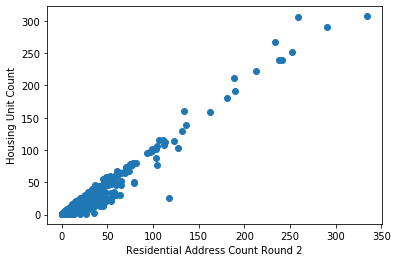

In [59]:
# Compare Bldg Count to Housing 10
x = census_blocks_df_rap2['residentialAP2v2']
y = census_blocks_df_rap2['apcount']
plt.scatter(x, y)
plt.xlabel("Residential Address Count Round 2")
plt.ylabel("Housing Unit Count")

## Error Check Options - Round 2


In [60]:
block_error_check_addresspoints(census_blocks_df_rap2,'apcount','residentialAP2v2','bldgcountv2','ErrorCheck2')
pd.crosstab(census_blocks_df_rap2['ErrorCheck1'], census_blocks_df_rap2['ErrorCheck2'], margins=True, margins_name="Total")

ErrorCheck2,1. HU=0,2. HU=AP,3. HU<AP,4. HU>AP,"8. HU > 0, Building Count = Missing","9. HU = 0, Building Count = Missing",Total
ErrorCheck1,,,,,,,
1. HU=0,238,0,0,0,0,0,238
2. HU=AP,0,479,0,0,0,0,479
3. HU<AP,0,0,746,0,0,0,746
4. HU>AP,0,66,29,232,0,0,327
"5. HU > 0, AP = 0",0,0,39,0,0,0,39
"8. HU > 0, Building Count = Missing",0,0,0,0,4733,0,4733
"9. HU = 0, Building Count = Missing",0,0,0,0,0,3059,3059
Total,238,545,814,232,4733,3059,9621


In [61]:
pd.crosstab(census_blocks_df_rap2['ErrorCheck2'], census_blocks_df_rap2['Joplin'], margins=True, margins_name="Total")

Joplin,Joplin,Not Joplin,Total
ErrorCheck2,,,
1. HU=0,222,16,238
2. HU=AP,485,60,545
3. HU<AP,746,68,814
4. HU>AP,183,49,232
"8. HU > 0, Building Count = Missing",31,4702,4733
"9. HU = 0, Building Count = Missing",358,2701,3059
Total,2025,7596,9621


### The Second Round has worked
79 blocks moved from too few AP to the same number of AP and HU, and 32 have moved from more AP than HU.
There are still 249 blocks with too few AP.
54 blocks with missing AP now have more AP than HU.

In [62]:
census_blocks_df_rap2['DiffCount2'] = census_blocks_df_rap2['apcount'] - census_blocks_df_rap2['residentialAP2v2']
census_blocks_df_rap2[['DiffCount1','DiffCount2']].describe()

,DiffCount1,DiffCount2
count,1591.000000,1591.000000
mean,-0.403520,-2.945946
std,16.947996,6.433176
min,-92.000000,-92.000000
25%,-4.000000,-4.000000
50%,0.000000,-1.000000
75%,0.000000,0.000000
max,261.000000,47.000000


In [63]:
# Compare difference in county by Error Type
census_blocks_df_rap2['DiffCount2'].groupby(census_blocks_df_rap2['ErrorCheck2']).describe()

,count,mean,std,min,25%,50%,75%,max
ErrorCheck2,,,,,,,,
1. HU=0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2. HU=AP,545.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
3. HU<AP,814.0,-6.461916,6.984988,-92.0,-9.0,-4.0,-1.25,-1.0
4. HU>AP,232.0,2.469828,4.433144,1.0,1.0,1.0,2.00,47.0
"8. HU > 0, Building Count = Missing",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"9. HU = 0, Building Count = Missing",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# For the 205 blocks that still have too few APs - looks like 72 out of 94 are in joplin
displaycols = ['BLOCKID10','apcount','bldgcount1_sum','bldgcountv2','DiffCount1','DiffCount2','residentialAP1_sum','residentialAP2v2']
census_blocks_df_rap2[displaycols].loc[
    (census_blocks_df_rap2['ErrorCheck1'] == "4. HU>AP") &
    (census_blocks_df_rap2['ErrorCheck2'] ==  "4. HU>AP") &
    (census_blocks_df_rap2['Joplin']=="Joplin")]

,BLOCKID10,apcount,bldgcount1_sum,bldgcountv2,DiffCount1,DiffCount2,residentialAP1_sum,residentialAP2v2
32,290970108004008,5.0,5.0,5.0,1.0,1.0,4.0,4.0
33,290970108001010,14.0,16.0,16.0,1.0,1.0,13.0,13.0
35,290970108004020,15.0,16.0,16.0,1.0,1.0,14.0,14.0
40,290970110002024,43.0,18.0,18.0,4.0,2.0,39.0,41.0
76,290970102001006,66.0,70.0,70.0,4.0,4.0,62.0,62.0
155,290970105001008,212.0,95.0,95.0,29.0,23.0,183.0,189.0
160,290970105003007,25.0,31.0,31.0,2.0,2.0,23.0,23.0
175,290970104001049,10.0,15.0,15.0,1.0,1.0,9.0,9.0
239,290970109002055,16.0,16.0,16.0,1.0,1.0,15.0,15.0
263,290970108005013,16.0,17.0,17.0,1.0,1.0,15.0,15.0


In [65]:
census_blocks_df_rap2[['DiffCount1','DiffCount2']].describe()

,DiffCount1,DiffCount2
count,1591.000000,1591.000000
mean,-0.403520,-2.945946
std,16.947996,6.433176
min,-92.000000,-92.000000
25%,-4.000000,-4.000000
50%,0.000000,-1.000000
75%,0.000000,0.000000
max,261.000000,47.000000


In [66]:
# Merge Block level data with building level data
census_blocks_df_rap2 = census_blocks_df_rap2.rename(index=str, columns={
    "residentialAP2v2": "residentialAP2v2_sum", 
    "bldgcountv2": "bldgcountv2_sum"})

In [67]:
keepcolumns = ['BLOCKID10','residentialAP2v2_sum','bldgcountv2_sum','DiffCount2','ErrorCheck2']
building_gdf_round2_v3 = pd.merge(building_gdf_round2_v2, census_blocks_df_rap2[keepcolumns], 
                                  left_on='BLOCKID10', right_on='BLOCKID10', how='left')
# Convert Pandas Data Frame from Merge to Geodataframe
building_gdf_round2_v3 = gpd.GeoDataFrame(building_gdf_round2_v3, crs=building_gdf.crs)
building_gdf_round2_v3['bldg_id'].describe()

count        28152
unique       28152
top       B0012554
freq             1
Name: bldg_id, dtype: object

In [68]:
building_gdf_round2_v3.head()

,Unnamed: 0,bldg_id,parid,BLOCKID10,STATEFP10,COUNTYFP10,TRACTCE10,PUMGEOID10,PUMNAME10,PLCGEOID10,...,DiffCount1,ErrorCheck1,Res_Area,Sum_Res_Area,residentialAP2,residentialAP2v2,residentialAP2v2_sum,bldgcountv2_sum,DiffCount2,ErrorCheck2
0,0,B0000001,P16703610001025000,290970102003000,29.0,97.0,10200.0,2902800.0,Jasper & Newton Counties PUMA,2937592.0,...,-24.0,3. HU<AP,107.940427,23104.086156,-0.112126,1.0,127.0,155.0,-24.0,3. HU<AP
1,1,B0000002,P16703610001028000,290970102003000,29.0,97.0,10200.0,2902800.0,Jasper & Newton Counties PUMA,2937592.0,...,-24.0,3. HU<AP,169.494274,23104.086156,-0.176067,1.0,127.0,155.0,-24.0,3. HU<AP
2,2,B0000003,P16703610001027000,290970102003000,29.0,97.0,10200.0,2902800.0,Jasper & Newton Counties PUMA,2937592.0,...,-24.0,3. HU<AP,0.000000,23104.086156,-0.000000,0.0,127.0,155.0,-24.0,3. HU<AP
3,3,B0000004,P16703610001029000,290970102003000,29.0,97.0,10200.0,2902800.0,Jasper & Newton Counties PUMA,2937592.0,...,-24.0,3. HU<AP,185.178358,23104.086156,-0.192359,1.0,127.0,155.0,-24.0,3. HU<AP
4,4,B0000005,P16703610001059000,290970102003000,29.0,97.0,10200.0,2902800.0,Jasper & Newton Counties PUMA,2937592.0,...,-24.0,3. HU<AP,202.291430,23104.086156,-0.210136,1.0,127.0,155.0,-24.0,3. HU<AP


### For Round 3 - 
I think the best option would be to simply add an additional address point to every structure in the block. This might cause some problems but it would also maximize the uncertainty in assigning housing unit data to buildings.

Text(0, 0.5, 'Housing Unit Count')

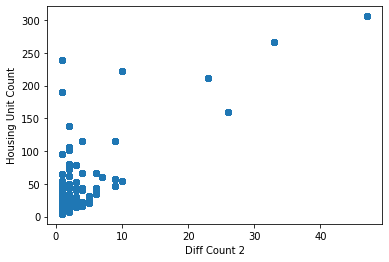

In [69]:
# Difference in Count for Blocks with fewer AP than Housing Units
x = building_gdf_round2_v3['DiffCount2'].loc[(building_gdf_round2_v3['ErrorCheck2']=="4. HU>AP")]
y = building_gdf_round2_v3['apcount'].loc[(building_gdf_round2_v3['ErrorCheck2']=="4. HU>AP")]
plt.scatter(x, y)
plt.xlabel("Diff Count 2")
plt.ylabel("Housing Unit Count")

In [70]:
# Create Round 3 version of Address Point Estiamte
building_gdf_round3_v1 = building_gdf_round2_v3
building_gdf_round3_v1['residentialAP3v1'] = building_gdf_round3_v1['residentialAP2v2']

In [71]:
building_gdf_round3_v1['residentialAP3v1'].loc[(building_gdf_round3_v1['ErrorCheck2']=="4. HU>AP")].describe()

count    5872.000000
mean        1.030654
std         1.292147
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        37.000000
Name: residentialAP3v1, dtype: float64

In [72]:
building_gdf_round3_v1.loc[(building_gdf_round3_v1['ErrorCheck2']=="4. HU>AP") &
                          (building_gdf_round2_v3['residentialAP2v2']>=1),
                           'residentialAP3v1'] = building_gdf_round3_v1['residentialAP3v1'] + 1
building_gdf_round3_v1['residentialAP3v1'].loc[(building_gdf_round3_v1['ErrorCheck2']=="4. HU>AP")].describe()

count    5872.000000
mean        1.824591
std         1.502699
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        38.000000
Name: residentialAP3v1, dtype: float64

## Sum Residential Addresspoints (third attempt) by blockid

In [73]:
# sum Buildings over the column BLOCKID.
# https://www.geeksforgeeks.org/python-pandas-dataframe-sum/
block_rap3_gdf = building_gdf_round3_v1[['BLOCKID10','residentialAP3v1']]
block_rap3_gdf['bldgcountv3'] = 1
block_rap3_gdf_sum = block_rap3_gdf.groupby(['BLOCKID10']).sum()
block_rap3_gdf_sum.head()

C:\Users\nathanael99\AppData\Local\Continuum\anaconda3\envs\pyincore20190618\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,residentialAP3v1,bldgcountv3
BLOCKID10,,
290970101001000,5.0,5
290970101001001,2.0,2
290970101001002,3.0,4
290970101001003,29.0,33
290970101001006,10.0,10


In [74]:
block_rap3_gdf_sum['residentialAP3v1'].describe()

count    1829.000000
mean       19.363040
std        31.013099
min         0.000000
25%         6.000000
50%        13.000000
75%        24.000000
max       471.000000
Name: residentialAP3v1, dtype: float64

## Error Check Round 3

In [75]:
census_blocks_df_rap2['BLOCKID10'].describe()

count    9.621000e+03
mean     2.911818e+14
std      2.383822e+11
min      2.909701e+14
25%      2.909701e+14
50%      2.909701e+14
75%      2.914502e+14
max      2.914502e+14
Name: BLOCKID10, dtype: float64

In [76]:
# Merge Sum of Residential Address Points with Census Counts
census_blocks_df_rap3 = pd.merge(census_blocks_df_rap2, block_rap3_gdf_sum,
                                  left_on='BLOCKID10', right_on='BLOCKID10', how='left')
census_blocks_df_rap3['BLOCKID10'].describe()

count    9.621000e+03
mean     2.911818e+14
std      2.383822e+11
min      2.909701e+14
25%      2.909701e+14
50%      2.909701e+14
75%      2.914502e+14
max      2.914502e+14
Name: BLOCKID10, dtype: float64

In [77]:
block_error_check_addresspoints(census_blocks_df_rap3,'apcount','residentialAP3v1','bldgcountv3','ErrorCheck3')
pd.crosstab(census_blocks_df_rap3['ErrorCheck2'], census_blocks_df_rap3['ErrorCheck3'], margins=True, margins_name="Total")

ErrorCheck3,1. HU=0,2. HU=AP,3. HU<AP,"8. HU > 0, Building Count = Missing","9. HU = 0, Building Count = Missing",Total
ErrorCheck2,,,,,,
1. HU=0,238,0,0,0,0,238
2. HU=AP,0,545,0,0,0,545
3. HU<AP,0,0,814,0,0,814
4. HU>AP,0,0,232,0,0,232
"8. HU > 0, Building Count = Missing",0,0,0,4733,0,4733
"9. HU = 0, Building Count = Missing",0,0,0,0,3059,3059
Total,238,545,1046,4733,3059,9621


In [78]:
pd.crosstab(census_blocks_df_rap3['ErrorCheck3'], census_blocks_df_rap3['Joplin'], margins=True, margins_name="Total")

Joplin,Joplin,Not Joplin,Total
ErrorCheck3,,,
1. HU=0,222,16,238
2. HU=AP,485,60,545
3. HU<AP,929,117,1046
"8. HU > 0, Building Count = Missing",31,4702,4733
"9. HU = 0, Building Count = Missing",358,2701,3059
Total,2025,7596,9621


In [79]:
pd.crosstab(building_gdf_round3_v1['residentialAP3v1'], building_gdf_round3_v1['archtype'], margins=True, margins_name="Total")

archtype,1,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Total
residentialAP3v1,,,,,,,,,,,,,,,,,
0.0,4427,30,604,659,141,20,40,5,28,38,21,18,24,90,6,437,6588
1.0,11649,13,80,174,8,13,7,3,9,39,3,3,2,118,0,147,12268
2.0,7003,16,22,85,4,3,1,0,1,6,1,0,1,156,0,75,7374
3.0,1242,13,18,19,1,2,2,0,1,4,2,0,0,15,0,39,1358
4.0,197,20,5,15,1,0,0,0,0,0,1,0,0,0,1,1,241
5.0,73,3,0,4,0,0,0,0,1,0,0,0,1,0,1,1,84
6.0,44,3,1,1,0,0,0,0,0,0,0,0,1,0,0,1,51
7.0,16,8,0,1,0,0,0,0,0,0,0,0,1,0,0,0,26
8.0,18,13,0,1,0,0,0,0,0,0,0,0,0,0,0,0,32


### Look at outliers in Archtype and Estimated counts
Small residential structure with more than 10 housing unts. Especially example of 141 housing units.

In [80]:
displaycols = ['BLOCKID10','bldg_id','archtype','PLCNAME10','COUNTYFP10','bldgcount1_sum','residentialAP3v1','apcount']
condition = building_gdf_round3_v1['residentialAP3v1']> 24
building_gdf_round3_v1[displaycols].loc[condition].sort_values(by=['residentialAP3v1'])

,BLOCKID10,bldg_id,archtype,PLCNAME10,COUNTYFP10,bldgcount1_sum,residentialAP3v1,apcount
12980,291450205012032,B0007913,5,Joplin,145.0,2.0,25.0,48.0
7972,290970103002027,B0023442,1,Joplin,97.0,45.0,29.0,239.0
10110,290970103002033,B0030074,1,Joplin,97.0,32.0,30.0,180.0
10109,290970103002033,B0030073,1,Joplin,97.0,32.0,31.0,180.0
11609,290970107001036,B0003766,1,Joplin,97.0,3.0,32.0,67.0
14182,290970106001016,B0012068,6,Joplin,97.0,3.0,33.0,36.0
10108,290970103002033,B0030072,1,Joplin,97.0,32.0,33.0,180.0
26149,291450205021078,B0025661,1,Shoal Creek Drive,145.0,1.0,35.0,35.0
4532,290970110002025,B0019637,1,Joplin,97.0,4.0,36.0,77.0
6243,290970101001080,B0021601,18,Joplin,97.0,4.0,37.0,59.0


### Block ID 290970104002019
Large block on the edge of Joplin. The block has only 1 building footprint - all of the housing units are assigned to the one building.

### Block ID 290970104001006
This is the large retirment home. The building type Archtype 1 - may not be the accurate building type.

### Block ID 290970101001063
This block also has a retirment home in tower. The Archtype 1 is not accurate.

### Block ID 290970103002033
This block is the campus of Missouri Southern State. There are apartments on campus. It might be possible to shift the residential units to the archtype 1 in this case.


### Block ID 290970101001080
Block has 4 buildings all appear to be shopping centers. The address 601 S MAIN ST is actually an apartment building. So the program is correct.

### Block ID 290970103002027
Block includes the rest of Missouri Southern State - with several dorms that are not being assigned any housing units. This might be a case where the dorm buildings could be identified and the Group Quarters Population could be distributed here. Otherwise this block does have a lot of apartment complexes and the program is distributing the bulck of the housing units to apartment buildings.
The 2 buildings in block 290970103002027 -B0023442 and  B0023543 - are a large apartment complex called college view manor.

In [81]:
# Save Work at this point - Save as CSV
savefile = sys.path[0]+"/"+programname+"/"+programname+"_huestimate_EPSG4326.csv"
building_gdf_round3_v1.to_csv(savefile)